In [293]:
import torch.nn as nn
import torch
class CondVAE(nn.Module):
    def __init__(self, dim_input, latent_dim=10):
        super(CondVAE, self).__init__()
        
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=dim_input, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=100),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(100, latent_dim)
        #self.fc_logvar =  nn.Sequential(nn.Linear(100, latent_dim),nn.Softplus())
        self.fc_logvar =  nn.Linear(100, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=6),
        )
        
        self.regressor = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=1),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        return mu, log_var
    
    def decode(self, z):
        
        return self.decoder(z)     
    
    def sampling(self, mu, log_var):
        # calculate standard deviation
        std = log_var.mul(0.5).exp_()
        # create noise tensor of same size as std to add to the latent vector
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        # multiply eps with std to scale the random noise according to the learned distribution + add combined
        return eps.mul(std).add_(mu) # return z sample 

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        
        return self.decode(z), self.regressor(z), mu, log_var


In [294]:
import tqdm
import torch
import torch.nn as nn

def condvae_loss(recons, pred, data_input, label, mu, logvar):
    """
    Calculate the conditional Variational Autoencoder (cVAE) loss.

    This function computes the cVAE loss, which consists of two components:
    - Reconstruction loss: Measures the discrepancy between the reconstructed
      data and the original input.
    - KL divergence loss: Quantifies the difference between the learned latent
      distribution and the desired prior distribution (Gaussian).

    Args:
        recon_x (torch.Tensor): Reconstructed data from the VAE.
        x (torch.Tensor): Original input data.
        mu (torch.Tensor): Latent variable mean.
        logvar (torch.Tensor): Logarithm of latent variable variance.

    Returns:
        torch.Tensor: Computed cVAE loss.
    """
    
    # MSE loss element-wise and sums up the individual losses
    regression_loss = nn.L1Loss(reduction='mean')(pred, label)
    decoder_loss = nn.L1Loss(reduction='mean')(recons, data_input)
    
    # quantifies the difference between the learned latent distribution and the desired prior distribution (Gaussian)
    kl_divergence =  0 #-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    
    return regression_loss + kl_divergence + decoder_loss

def VAE_trainEpoch(model, optimizer, train_loader, dim_in=100):
    """
    Train a Variational Autoencoder (VAE) for one epoch.

    This function trains a VAE for one epoch using the provided data loader.
    It calculates the cVAE loss, performs backpropagation, and updates the model's parameters.

    Args:
        model (nn.Module): VAE model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        train_loader (DataLoader): DataLoader containing training data.
        dim_in (int): Dimensionality of the input noise.

    Returns:
        float: Average loss for the epoch.
    """
    model = model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_loss = 0

    progress_bar = tqdm.tqdm(train_loader, desc="Epoch Progress", leave=False)
    for data, label in progress_bar:
        data = data.to(device)
        label = label.unsqueeze(1).cuda()
        optimizer.zero_grad()


        recon_batch, pred_batch, mu, log_var = model(data)
        loss = condvae_loss(recon_batch, pred_batch, data, label, mu, log_var)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": total_loss / (progress_bar.n + 1)})

    return total_loss / len(train_loader)

def VAE_train(model, optimizer, train_loader, epochs, dim_in, save_path=None):
    """
    Train a Variational Autoencoder (VAE) for multiple epochs.

    This function trains a VAE for the specified number of epochs using the provided data loader.
    It prints the epoch progress and the computed loss for each epoch.

    Args:
        model (nn.Module): VAE model to be trained.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        train_loader (DataLoader): DataLoader containing training data.
        epochs (int): Number of epochs for training.

    Returns:
        None
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = VAE_trainEpoch(model, optimizer, train_loader, dim_in)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        
    if save_path!=None:
        torch.save(model, save_path)



In [295]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [296]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [297]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats

In [298]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [65]:
photoz_archive = archive(path = parent_dir, Qz_cut=1)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [299]:
dset = TensorDataset(torch.Tensor(f),torch.Tensor(specz))
loader = DataLoader(dset, batch_size=100, shuffle=True)

In [300]:
dim_input=6
latent_dim=1
epochs=100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [301]:
vae = CondVAE(dim_input, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-4)


In [302]:
VAE_train(vae, optimizer, loader, epochs, dim_input, save_path=None)

Epoch 1/100


Epoch 1/100, Loss: 0.7994
Epoch 2/100


Epoch 2/100, Loss: 0.7418
Epoch 3/100


Epoch 3/100, Loss: 0.7436
Epoch 4/100


Epoch 4/100, Loss: 0.7406
Epoch 5/100


Epoch 5/100, Loss: 0.7395
Epoch 6/100


Epoch 6/100, Loss: 0.7416
Epoch 7/100


Epoch 7/100, Loss: 0.7402
Epoch 8/100


Epoch 8/100, Loss: 0.7400
Epoch 9/100


Epoch 9/100, Loss: 0.7397
Epoch 10/100


Epoch 10/100, Loss: 0.7380
Epoch 11/100


Epoch 11/100, Loss: 0.7407
Epoch 12/100


Epoch 12/100, Loss: 0.7381
Epoch 13/100


Epoch 13/100, Loss: 0.7408
Epoch 14/100


Epoch 14/100, Loss: 0.7390
Epoch 15/100


Epoch 15/100, Loss: 0.7387
Epoch 16/100


Epoch 16/100, Loss: 0.7384
Epoch 17/100


Epoch 17/100, Loss: 0.7382
Epoch 18/100


Epoch 18/100, Loss: 0.7377
Epoch 19/100


Epoch 19/100, Loss: 0.7382
Epoch 20/100


Epoch 20/100, Loss: 0.7383
Epoch 21/100


Epoch 21/100, Loss: 0.7385
Epoch 22/100


Epoch 22/100, Loss: 0.7376
Epoch 23/100


Epoch 23/100, Loss: 0.7372
Epoch 24/100


Epoch 24/100, Loss: 0.7380
Epoch 25/100


Epoch 25/100, Loss: 0.7373
Epoch 26/100


Epoch 26/100, Loss: 0.7374
Epoch 27/100


Epoch 27/100, Loss: 0.7373
Epoch 28/100


Epoch 28/100, Loss: 0.7367
Epoch 29/100


Epoch 29/100, Loss: 0.7371
Epoch 30/100


Epoch 30/100, Loss: 0.7370
Epoch 31/100


Epoch 31/100, Loss: 0.7377
Epoch 32/100


Epoch 32/100, Loss: 0.7372
Epoch 33/100


Epoch 33/100, Loss: 0.7365
Epoch 34/100


Epoch 34/100, Loss: 0.7374
Epoch 35/100


Epoch 35/100, Loss: 0.7362
Epoch 36/100


Epoch 36/100, Loss: 0.7370
Epoch 37/100


Epoch 37/100, Loss: 0.7367
Epoch 38/100


Epoch 38/100, Loss: 0.7370
Epoch 39/100


Epoch 39/100, Loss: 0.7363
Epoch 40/100


Epoch 40/100, Loss: 0.7367
Epoch 41/100


Epoch 41/100, Loss: 0.7368
Epoch 42/100


Epoch 42/100, Loss: 0.7376
Epoch 43/100


Epoch 43/100, Loss: 0.7364
Epoch 44/100


Epoch 44/100, Loss: 0.7368
Epoch 45/100


Epoch 45/100, Loss: 0.7366
Epoch 46/100


Epoch 46/100, Loss: 0.7366
Epoch 47/100


Epoch 47/100, Loss: 0.7371
Epoch 48/100


Epoch 48/100, Loss: 0.7367
Epoch 49/100


Epoch 49/100, Loss: 0.7362
Epoch 50/100


Epoch 50/100, Loss: 0.7362
Epoch 51/100


Epoch 51/100, Loss: 0.7366
Epoch 52/100


Epoch 52/100, Loss: 0.7361
Epoch 53/100


Epoch 53/100, Loss: 0.7364
Epoch 54/100


Epoch 54/100, Loss: 0.7363
Epoch 55/100


Epoch 55/100, Loss: 0.7362
Epoch 56/100


Epoch 56/100, Loss: 0.7369
Epoch 57/100


Epoch 57/100, Loss: 0.7366
Epoch 58/100


Epoch 58/100, Loss: 0.7361
Epoch 59/100


Epoch 59/100, Loss: 0.7364
Epoch 60/100


Epoch 60/100, Loss: 0.7368
Epoch 61/100


Epoch 61/100, Loss: 0.7362
Epoch 62/100


Epoch 62/100, Loss: 0.7361
Epoch 63/100


Epoch 63/100, Loss: 0.7375
Epoch 64/100


Epoch 64/100, Loss: 0.7364
Epoch 65/100


Epoch 65/100, Loss: 0.7369
Epoch 66/100


Epoch 66/100, Loss: 0.7360
Epoch 67/100


Epoch 67/100, Loss: 0.7361
Epoch 68/100


Epoch 68/100, Loss: 0.7364
Epoch 69/100


Epoch 69/100, Loss: 0.7363
Epoch 70/100


Epoch 70/100, Loss: 0.7360
Epoch 71/100


Epoch 71/100, Loss: 0.7364
Epoch 72/100


Epoch 72/100, Loss: 0.7366
Epoch 73/100


Epoch 73/100, Loss: 0.7364
Epoch 74/100


Epoch 74/100, Loss: 0.7363
Epoch 75/100


Epoch 75/100, Loss: 0.7360
Epoch 76/100


Epoch 76/100, Loss: 0.7366
Epoch 77/100


Epoch 77/100, Loss: 0.7364
Epoch 78/100


Epoch 78/100, Loss: 0.7365
Epoch 79/100


Epoch 79/100, Loss: 0.7365
Epoch 80/100


Epoch 80/100, Loss: 0.7367
Epoch 81/100


Epoch 81/100, Loss: 0.7368
Epoch 82/100


Epoch 82/100, Loss: 0.7366
Epoch 83/100


Epoch 83/100, Loss: 0.7360
Epoch 84/100


Epoch 84/100, Loss: 0.7358
Epoch 85/100


Epoch 85/100, Loss: 0.7368
Epoch 86/100


Epoch 86/100, Loss: 0.7363
Epoch 87/100


Epoch 87/100, Loss: 0.7359
Epoch 88/100


Epoch 88/100, Loss: 0.7364
Epoch 89/100


Epoch 89/100, Loss: 0.7361
Epoch 90/100


Epoch 90/100, Loss: 0.7365
Epoch 91/100


Epoch 91/100, Loss: 0.7361
Epoch 92/100


Epoch 92/100, Loss: 0.7367
Epoch 93/100


Epoch 93/100, Loss: 0.7362
Epoch 94/100


Epoch 94/100, Loss: 0.7361
Epoch 95/100


Epoch 95/100, Loss: 0.7362
Epoch 96/100


Epoch 96/100, Loss: 0.7363
Epoch 97/100


Epoch 97/100, Loss: 0.7363
Epoch 98/100


Epoch 98/100, Loss: 0.7363
Epoch 99/100


Epoch 99/100, Loss: 0.7364
Epoch 100/100


Epoch 100/100, Loss: 0.7364


In [305]:
f_test, ferr_test, specz_test = photoz_archive.get_testing_data()

In [306]:
Ntest=10

In [307]:
datain = torch.Tensor(f_test[:10]).to(device)
x = vae.encoder(datain)
mu = vae.fc_mu(x)
log_var = vae.fc_logvar(x)
Nsamp=1000

In [308]:
datain

tensor([[1.1479, 0.3912, 0.8374, 0.7508, 1.2488, 0.8488],
        [0.3916, 0.8170, 0.9124, 0.8022, 0.9451, 0.9885],
        [0.3894, 0.5246, 0.9165, 0.8517, 0.8625, 0.8356],
        [0.4891, 0.5986, 0.9832, 0.7717, 0.9078, 0.8872],
        [0.1693, 0.4140, 0.6905, 0.7985, 0.7315, 0.5996],
        [0.1097, 0.3383, 0.4823, 0.7898, 0.7083, 0.6996],
        [0.5493, 0.6261, 1.0609, 0.7438, 0.8732, 0.9139],
        [0.5659, 0.6637, 0.8864, 0.9856, 0.8920, 0.7977],
        [0.3160, 0.3441, 0.4192, 0.6507, 0.6579, 0.5727],
        [0.7710, 0.5087, 0.7844, 0.9328, 0.7800, 0.8684]], device='cuda:0')

In [309]:
mu

tensor([[-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06],
        [-3.4548e-06]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [310]:
torch.exp(log_var)

tensor([[2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000]], device='cuda:0', grad_fn=<ExpBackward0>)

In [311]:
import torch.distributions as D


In [312]:
torch.exp(log_var[ii].cpu())

tensor([2.0000], grad_fn=<ExpBackward0>)

In [313]:
vae = vae.eval()
z_dim=1
py_z = np.zeros(shape=(Ntest,Nsamp))
px_z = np.zeros(shape=(Ntest,Nsamp,6))
pz= np.zeros(shape=(Ntest,Nsamp))

for ii in range(Ntest):
    base_distribution = D.Normal(mu[ii].cpu()*torch.ones(z_dim), torch.exp(log_var[ii].cpu())*torch.ones(z_dim))
    for jj in range(Nsamp):
        z = vae.sampling(mu[ii],log_var[ii])        

        py_z[ii,jj] = vae.regressor(z.to(device)).detach().cpu().numpy()
        px_z[ii,jj,:] = vae.decode(z.to(device)).detach().cpu().numpy()
        pz[ii,jj] = base_distribution.log_prob(z.cpu())


In [314]:
np.exp(pz)

array([[0.12801583, 0.17218088, 0.1873554 , ..., 0.14763936, 0.15918671,
        0.10822631],
       [0.17516595, 0.19795613, 0.10892031, ..., 0.09822501, 0.19940973,
        0.15055025],
       [0.16263473, 0.17919608, 0.14378181, ..., 0.19080766, 0.19529714,
        0.18262688],
       ...,
       [0.0383369 , 0.1969846 , 0.19438929, ..., 0.15335193, 0.19859305,
        0.19859523],
       [0.18836775, 0.19947221, 0.15643367, ..., 0.19192475, 0.19785437,
        0.19929699],
       [0.19779257, 0.14646251, 0.19313204, ..., 0.19487876, 0.19082342,
        0.18486699]])

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

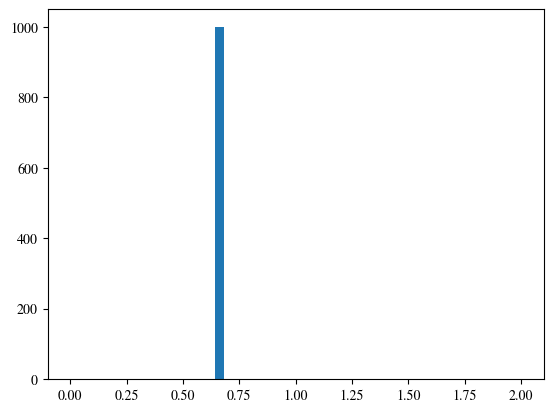

In [316]:
plt.hist(py_z[m], bins =50, range =(0,2))

In [318]:
specz_test[m]

1.103